In [7]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
import os
import re
import time
import math
from matplotlib import pyplot as plt
from collections import defaultdict
from itertools import combinations
import networkx as nx
from scipy.stats import pearsonr
from concurrent.futures import ProcessPoolExecutor
import ast

## Create Layer 1

In [8]:
import networkx as nx
import ast

def create_layer1_threshold(edges_dict, k_value, undirected=False):
    """
    Create a network layer by filtering edges based on a threshold and normalizing weights using min-max normalization.

    Args:
        edges_dict (dict): Dictionary containing edge data, where keys are edge tuples (as strings)
                           and values are dictionaries with weight data.
        threshold (float): Threshold for including edges in the graph.
        undirected (bool): Whether the graph is undirected or directed.

    Returns:
        nx.Graph or nx.DiGraph: A graph object containing edges that pass the threshold.
    """
    # Step 1: Extract all weights to find min and max values
    if undirected:
        weights = [edge_data['simmetric_weight'] for edge_data in edges_dict.values()]
    else:
        weights = [
            weight 
            for edge_data in edges_dict.values() 
            for weight in (edge_data['weight_user1'], edge_data['weight_user2'])
        ]
    threshold = np.percentile(np.array(weights), k_value)
    # Compute min and max weights for normalization
    w_min = min(weights)
    w_max = max(weights)

    # Avoid division by zero in case all weights are the same
    if w_max == w_min:
        normalize = lambda w: 1.0  # Set all normalized weights to 1.0
    else:
        normalize = lambda w: (w - w_min) / (w_max - w_min)  # Min-max normalization

    threshold = (threshold -w_min) / (w_max - w_min)
    # Step 2: Create the graph
    if undirected:
        G = nx.Graph()
        for edge, edge_data in edges_dict.items():
            e = ast.literal_eval(edge)
            normalized_weight = normalize(edge_data['simmetric_weight'])
            if normalized_weight > threshold:
                G.add_edge(e[0], e[1], weight=normalized_weight)
    else:
        G = nx.DiGraph()
        for edge, edge_data in edges_dict.items():
            e = ast.literal_eval(edge)
            normalized_weight_user1 = normalize(edge_data['weight_user1'])
            normalized_weight_user2 = normalize(edge_data['weight_user2'])
            if normalized_weight_user1 > threshold:
                G.add_edge(e[0], e[1], weight=normalized_weight_user1)
            if normalized_weight_user2 > threshold:
                G.add_edge(e[1], e[0], weight=normalized_weight_user2)

    return G


def get_percentile(edges, k_value):
    weights = []
    for edge, edge_dict in edges.items():
        weights.append(edge_dict['simmetric_weight'])
    return np.percentile(np.array(weights), k_value)

In [9]:
file_path = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/edges_dict_weight.json'
with open(file_path, "r") as json_file:
    edges_dict = json.load(json_file)

In [ ]:
layer1 = create_layer1_threshold(edges_dict, 90, undirected=True)

## Create Layer 3

In [3]:
def contains_keyword(string, keywords):
    return any(keyword in string for keyword in keywords)

def create_edges(all_events, keywords):
    edges = []
    addresses = list(all_events.keys())
    for address, events in all_events.items():
        for event in events:
            nft_description = event.get('nft_description')

            if nft_description and "DCL Wearable" in nft_description:
                continue

            if event.get('nft_name') and contains_keyword(event.get('nft_name'), keywords):
                continue

            if event.get('from') == address and event.get('to') in addresses and event.get('to') != address:

                edges.append([address, event.get('to'), 1])
            if event.get('seller') == address and event.get('buyer') in addresses and event.get('buyer') != address:

                edges.append([address, event.get('buyer'), 1+event.get('price', 0)])

    return edges

In [12]:
file_path = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/address_to_events_final.json'
with open(file_path, "r") as json_file:
    address_to_events = json.load(json_file)

In [13]:
# Creating wearables windows for each address
keywords = ["decentraland", "dcl", "decentral", "wearable", "decentral-games", "parcel", "MANA", 'Decentraland']
edges = create_edges(address_to_events, keywords=keywords)

In [14]:
edges_dict = {}
for edge in edges:
    e = tuple(set(edge[0:2]))
    if e not in edges_dict.keys():
        edges_dict[e] = edge[2]
    else:
        edges_dict[e] += edge[2]

In [15]:
layer3 = nx.Graph()
for edge, weight in edges_dict.items():
    layer3.add_edge(edge[0], edge[1], weight=weight)

## Null model

In [16]:
import networkx as nx
import random

def double_edge_swap_preserve_weights(G, nswap, max_tries=100):
    """
    Perform double edge swaps on a graph while preserving edge weights.

    Parameters:
        G (nx.Graph): Input graph with weights on edges.
        num_swaps (int): Number of swaps to perform.
        max_tries (int): Maximum number of attempts to perform the swaps.

    Returns:
        nx.Graph: A graph with rewired edges, preserving weights.
    """
    # Step 1: Extract edge weights
    original_weights = [
        data.get('weight') for _, _, data in G.edges(data=True)
    ]

    # Step 2: Perform double edge swaps
    nx.double_edge_swap(G, nswap=nswap, max_tries=max_tries)

    # Step 3: Reassign weights to the new edges

    random.shuffle(original_weights)
    #print(len(original_weights))
    #print(len(G.edges()))
    for i,(u, v) in enumerate(G.edges()):
        G[u][v]['weight'] = original_weights[i]
        

    return G


In [17]:
def check_degree_distribution(original_dd, null_model_dd):
    for degree, frequency in original_dd.items():
        if degree not in null_model_dd and frequency != 0:
            return False
        if frequency != null_model_dd[degree]:
            return False
    return True

## Metrics

In [18]:
from scipy.stats import pearsonr, spearmanr 

def calculate_layer_correlation(layer1, layer2):
    edges1 = {(u, v): d['weight'] for u, v, d in layer1.edges(data=True)}
    edges2 = {(u, v): d['weight'] for u, v, d in layer2.edges(data=True)}

    common_edges = set(edges1.keys()).intersection(set(edges2.keys()))
    weights1 = [edges1[edge] for edge in common_edges]
    weights2 = [edges2[edge] for edge in common_edges]
    #print(np.cov(weights1, weights2))

    return spearmanr(weights1, weights2)


In [19]:
import numpy as np
from scipy.stats import spearmanr

def analyze_layer_correlation(layer1, layer2, weights1, weights2):
    """
    Analyze correlation and overlap between two layers.

    Args:
        layer1 (set): Edge set of the first layer (e.g., {(u, v), ...}).
        layer2 (set): Edge set of the second layer.
        weights1 (dict): Weights of edges in the first layer, e.g., {(u, v): weight}.
        weights2 (dict): Weights of edges in the second layer, e.g., {(u, v): weight}.
    
    Returns:
        dict: Metrics including Spearman correlation, edge overlap, and composite score.
    """
    # Find common edges
    common_edges = layer1 & layer2
    num_common_edges = len(common_edges)
    
    # Edge overlap ratio
    edge_overlap_ratio = num_common_edges / min(len(layer1), len(layer2))
    
    # Extract weights for common edges
    common_weights1 = [weights1[edge] for edge in common_edges]
    common_weights2 = [weights2[edge] for edge in common_edges]
    
    # Compute Spearman correlation
    if len(common_edges) > 1:
        correlation, _ = spearmanr(common_weights1, common_weights2)
    else:
        correlation = 0  # Not enough data for correlation
    
    # Composite score (adjust alpha as needed)
    alpha = 0.5
    composite_score = alpha * correlation + (1 - alpha) * edge_overlap_ratio
    
    return {
        "correlation": correlation,
        "edge_overlap_ratio": edge_overlap_ratio,
        "composite_score": composite_score,
        "num_common_edges": num_common_edges,
    }



## Overlap

In [20]:
print(f'Number of edges (layer 2): {layer1.number_of_edges()}')
print(f'Number of nodes (layer2): {layer1.number_of_nodes()}')
print(f'Number of edges (layer 3): {layer3.number_of_edges()}')
print(f'Number of nodes (layer3): {layer3.number_of_nodes()}')
print(f'Density (layer2): {nx.density(layer3)}')

Number of edges (layer 2): 55052
Number of nodes (layer2): 2599
Number of edges (layer 3): 1936
Number of nodes (layer3): 799
Density (layer2): 0.006072753849580146


Sarebbe opportuno fare almeno 10N swaps (N è il numero di edges del network). Nel nostro caso N = 18592 quindi eseguiamo 200000 swaps.

In [21]:
scores = []
N = 100
for i in range(N):
    print(f'Iteration {i}')
    layer3_copy = layer3.copy()
    null_model = double_edge_swap_preserve_weights(layer3_copy, nswap=20000, max_tries=1000000)
    # original_dd = {n:d for n, d in layer2_copy.degree()}
    # null_model_dd = {n:d for n, d in null_model.degree()}
    # print(f'Degree distributions are equal: {check_degree_distribution(original_dd, null_model_dd)}')
    weights1 = {(u, v): d['weight'] for u, v, d in layer1.edges(data=True)}
    weights2 = {(u, v): d['weight'] for u, v, d in null_model.edges(data=True)}
    
    score = analyze_layer_correlation(set(layer1.edges()), set(null_model.edges()), weights1, weights2)
    scores.append(score)


Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

0.35 secondi a iterazione -> circa 6 minuti per 1000

In [53]:
file_path = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/scores.json'
with open(file_path, "w") as json_file:
    json.dump(scores, json_file)

## Overlap study

In [185]:
file_path = '/Users/HP/Desktop/UNI/LM_1/ACN/ACN_project/data/scores_carlo.json'
with open(file_path, "r") as json_file:
    scores = json.load(json_file)

In [22]:
correlations = []
edge_overlap_ratios = []
composite_scores = []
for elem in scores:
    composite_scores.append(elem['composite_score'])
    correlations.append(elem['correlation'])
    edge_overlap_ratios.append(elem['edge_overlap_ratio'])

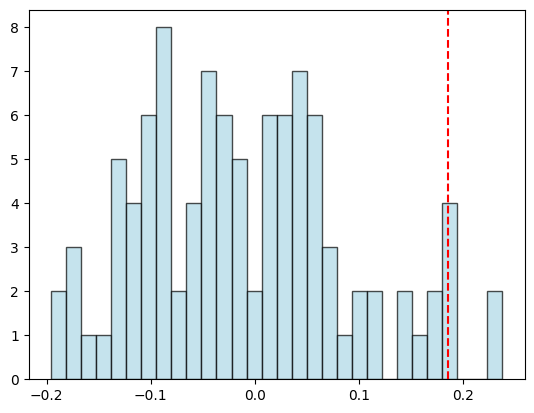

In [24]:
plt.hist(correlations, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')
expected_correlation = calculate_layer_correlation(layer1, layer3)[0]
plt.axvline(expected_correlation, color='red', linestyle='--', label="Observed")

In [25]:
%matplotlib qt
plt.hist(edge_overlap_ratios, bins=30, alpha=0.7, label="Null Model", color='lightblue', edgecolor='black')
expected_commons = len(set(layer3.edges()).intersection(set(layer1.edges())))
expected_edge_overlap_ratio = expected_commons / min(layer3.number_of_edges(), layer1.number_of_edges())
print(f'Expected edge overlap ratio: {expected_edge_overlap_ratio}')
print(f'Mean edge overlap ratio: {np.mean(edge_overlap_ratios)}')
print(f'Standard deviation edge overlap ratio: {np.std(edge_overlap_ratios)}')
plt.xlabel('Edge-overlap ratio', size=25)
plt.ylabel('Frequency', size=25)
plt.title('Edge-overlap ratio Distribution', size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.axvline(np.mean(edge_overlap_ratios), color='green', linestyle='--', label=f"Mean = {np.mean(edge_overlap_ratios):.2f}")
plt.axvline(expected_edge_overlap_ratio, color='red', linestyle='--', label=f"Observed = {expected_edge_overlap_ratio:.2f}")
plt.legend(fontsize=20)
plt.show()

Expected edge overlap ratio: 0.1131198347107438
Mean edge overlap ratio: 0.049953512396694225
Standard deviation edge overlap ratio: 0.004364162032222715


## z-test

In [25]:
import numpy as np

def compute_z_value(null_model_ratios, original_ratio):
    """
    Computes the z-value for the original edge overlap ratio compared to null models.
    
    Parameters:
    - null_model_ratios (array-like): Array of edge overlap ratios from null models.
    - original_ratio (float): Edge overlap ratio from the original dataset.
    
    Returns:
    - z_value (float): The z-value of the original ratio.
    """
    # Calculate the mean and standard deviation of the null models
    mean_null = np.mean(null_model_ratios)
    std_null = np.std(null_model_ratios)  # Use ddof=1 for sample standard deviation
    
    # Compute the z-value
    z_value = (original_ratio - mean_null) / (std_null/np.sqrt(len(null_model_ratios)))
    
    return z_value


In [26]:
expected_commons = len(set(layer3.edges()).intersection(set(layer2.edges())))
expected_edge_overlap_ratio = expected_commons / min(layer3.number_of_edges(), layer2.number_of_edges())
print(f'z-value: {compute_z_value(edge_overlap_ratios, expected_edge_overlap_ratio)}')

z-value: 1392.0958523076044
